# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [65]:
import pandas as pd # импорт библиотеки pandas

In [70]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t') # считываем файл в data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

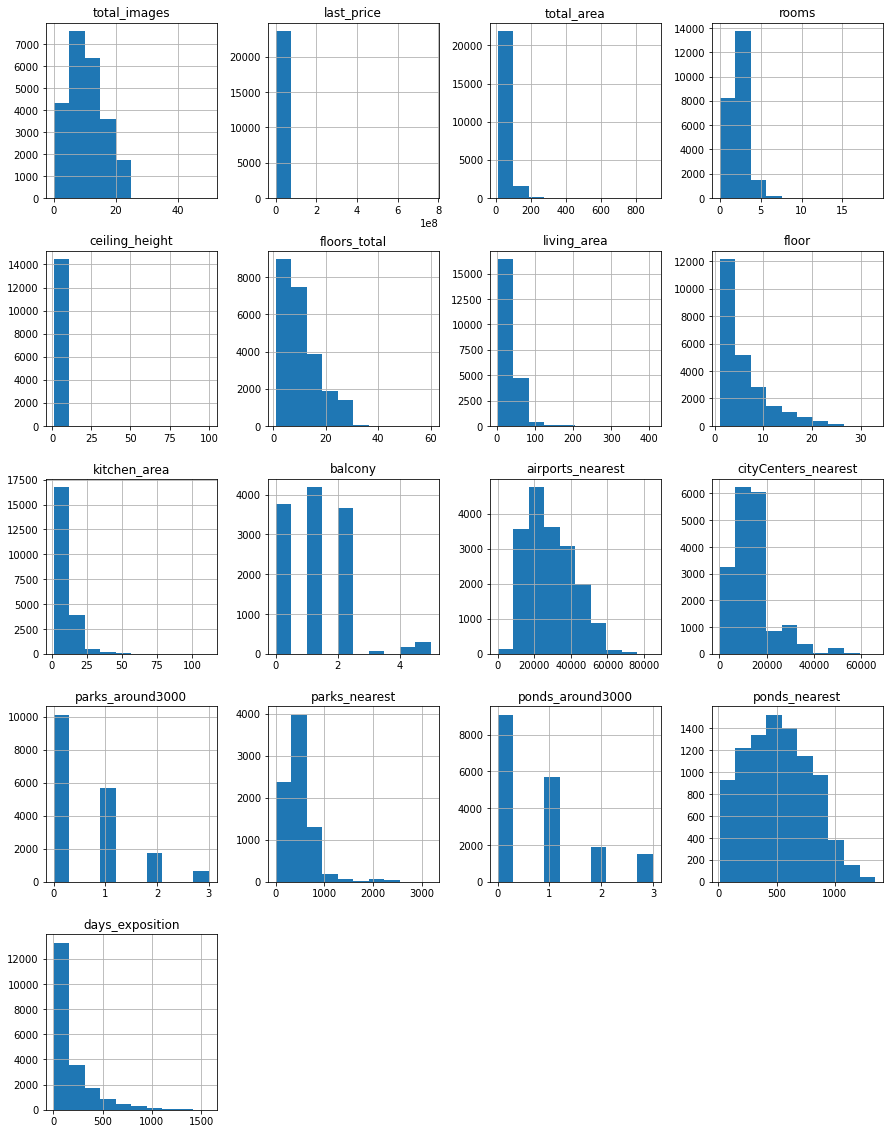

In [3]:
data.info() # Общая информация о данных
print(data.isna().sum()) # количество nan-данных
print(data.head()) # вывод первых 5 строк
data.hist(figsize=(15, 20)) # построение гистограмм по всем возможным данным

### Выполните предобработку данных

In [5]:
# приводим имена столбцов к одному формату
data = data.rename(columns={'cityCenters_nearest':'city_center_nearest'})

In [6]:
data['balcony'] = data['balcony'].fillna(0).astype('int') # заполняем пропуски в балконах
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int') # парках в округе 3000 м
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int') # и прудах в округе 3000 м нулями

data['airports_nearest'].fillna(0,inplace=True) # заполняем пропуски в наличии аэропорта

data['floors_total'] = data['floors_total'].fillna(0).astype('int') # заполняем пропуски в общей этажности дома

data['is_apartment'].unique() # проверка вариантов значений заполнения
data['is_apartment'] = data['is_apartment'].fillna('False').astype('bool') # отсутствие заполнения = False


data['parks_nearest'].fillna(3001,inplace=True) # заполняем расстояние до ближайшего парка
data['ponds_nearest'].fillna(3001,inplace=True) # и пруда

Пропуски в кол-ве балконов, прудов и парков в радиусе 3км подразумеваем отсутствием, т.е. = 0. Делаем столбец целочисленным,т.к. дробными эти числа быть не могут.

То же самое делаем и для пропусков в растоянии до аэропорта. Тип данных оставляем как есть - вещественным.

Строки с пропусками в количестве этажей обнуляем, чтобы в дальнейшем можно было такие объявления отсортировать.
Тип данных - целочисленный, этаж дробный быть не может.

Cтолбец is_apartment: да\нет. Если не указано, берем "нет"(заполняем 'False'). Тип столбца - логический.

Пропуски в расстояниях до парков и прудов были собраны автоматически по данным от заказчика и их отсутствие означает, что расстояние до ближайщего парка/пруда > 3000м. Поэтому заменяем на 3001. Чтобы на графике это выводилось отдельными показателями.

In [7]:
# форматируем столбец с датой размещения объявления
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

In [8]:
data['locality_name'] = data['locality_name'].fillna('Не указано')# заполняем пропущенные данные населенного пункта

# избавляемся от неявных дубликатов в названиях населеных пунктов
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['[а-я, ]*поселок[а-я, ]* ','деревня ','садов[а-я, ]*','село '], '', regex=True)
)

Если населенный пункт пропущен, то он "Не указан". Логично )

In [9]:
# заполняем пропуски в living_area и kitchen_area медианными значениями для квартир
# аналогичной комнатности

# создаем сводную таблицу для мединанных значений 'living_area' и 'kitchen_area' с группировкой по количеству комнат
pt = data.pivot_table(index='rooms',values=['living_area','kitchen_area'],aggfunc=['mean'])

# функции заполнения пропущенных значений 'living_area' и 'kitchen_area'
def living_area_fill(row):
    if row['living_area']!=row['living_area']:
        return pt.loc[row['rooms']]['mean']['living_area']
    else:
        return row['living_area']
    
def kitchen_area_fill(row):
    if row['kitchen_area']!=row['kitchen_area']:
        if row['rooms']>0:
            return pt.loc[row['rooms']]['mean']['kitchen_area']
        else:
            return row['total_area']-row['living_area']
    else:
        return row['kitchen_area']
    
# заполняем пропущенные значения    
data['living_area'] = data.apply(living_area_fill, axis=1)
data['kitchen_area'] = data.apply(kitchen_area_fill, axis=1)

да, функции повторяют друг друга. Не красиво. Как это оптимизировать - я не придумал.

In [10]:
# заполняем высоту потолков медианой
data['ceiling_height'].fillna(data['ceiling_height'].mean(),inplace=True)

# высоты потолков более 19 метров считаем ошибками ввода и делим их на 10
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x/10 if x>19 else x)

In [11]:
data['days_exposition'].fillna(-1, inplace=True) # заполняем пропуски в столбце days_exposition

Предполагаем, что пропущенные значения в столбце days_exposition означают, что квартира на момент предоставления данных находится в продаже, поэтому заполним их -1

In [12]:
data['city_center_nearest'].fillna(0, inplace=True) # заполняем пропуски в city_center_nearest
data['city_center_nearest'].astype('int') # меняем тип данных на int

# создаем сводную таблицу по медианным расстояниям от центра города для всех упомянутых населенных пунктов
pt = data.pivot_table(index='locality_name',values=['city_center_nearest'], aggfunc=['mean'])

# функция меняет 0 в столбце city_center_nearest на медианное значение для данного населенного пункта. Иначе возвращает текущее.
def try_to_fill_city_center_nearest(row):
    if row['city_center_nearest']==0:
        return pt.loc[row['locality_name']]['mean']['city_center_nearest']
    else:
        return row['city_center_nearest']

# заполняем столбец функцией
data['city_center_nearest'] = data.apply(try_to_fill_city_center_nearest, axis=1)

print('Количество явных дубликатов:',data.duplicated().mean())

Количество явных дубликатов: 0.0


Заменяем пропущенные значения в колонке city_center_nearest нулямя, чтобы можно было сделать сводную таблицу для всех населенных пунктов. Меняет тип столбца на int. Точность в метрах не нужна

На этом предобработка исходных данных завершена. В таблице было достаточно много пропусков, как полученных от ручного ввода, так и от автоматизированного. Все они были заполнены подходящими по смыслу или медианным значением. 
Можно дать рекомендации разработчикам (или сотрудникам, ответственным за сбор подобных данных) по минимизации пропусков:
1. ввести проверку полей ручного ввода и сделать их или обязательными или с возможностью выбора из списка значений
2. автоматически полученные данные должны обязательно иметь какое-либо значение. Полностью исключить пропуски. Это возможно.

### Добавьте в таблицу новые столбцы

In [13]:
# функция перевода номера дня недели в его название
def num_to_day(num):
    weekdays={0:'ПН',1:'ВТ',2:'СР',3:'ЧТ',4:'ПТ',5:'СБ',6:'ВС'}
    return(weekdays[num])

# функция определения типа этажа: "первый", "последний", "другое", если не то и не то.
def type_of_floor(row):
    if (row['floor'] > 1) & (row['floor'] == row['floors_total']):
        return 'Последний этаж'
    elif (row['floor'] == 1) & (row['floors_total'] > 1):
        return 'Первый этаж'
    else:
        return 'Другое'

In [14]:
import numpy as np # импорт numpy для использования функции ceil

In [15]:
data['1m_price'] = data['last_price']/data['total_area'] # добавляем столбец цены за 1 кв.метра

# добавляем столбцы для даты размещения объявления: день недели, месяц, год    
data['day_of_week'] = data['first_day_exposition'].dt.weekday.apply(num_to_day)
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

   
data['floor_type'] = data.apply(type_of_floor, axis=1) # добавляем столбец функцией с типом этажа
# проверим работу функции, выведя уникальные значения нового столбца
print('Значения нового столбца',data['floor_type'].unique()) 

# Записываем столбец city_center_nearest_km
data['city_center_nearest_km'] = (
    (data['city_center_nearest']/1000)# переводим расстояние до центра города из метров в километры.
    .apply(np.ceil) # округляем вверх
    .astype('int',copy=False) # меняем тип данных на int
    )

Значения нового столбца ['Другое' 'Первый этаж' 'Последний этаж']


In [16]:
# поменяем тип данных на целочисленный для цены и количества дней на продаже
data['last_price'] = data['last_price'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')

# посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23699 non-null  int64         
 1   last_price              23699 non-null  int64         
 2   total_area              23699 non-null  float64       
 3   first_day_exposition    23699 non-null  datetime64[ns]
 4   rooms                   23699 non-null  int64         
 5   ceiling_height          23699 non-null  float64       
 6   floors_total            23699 non-null  int64         
 7   living_area             23699 non-null  float64       
 8   floor                   23699 non-null  int64         
 9   is_apartment            23699 non-null  bool          
 10  studio                  23699 non-null  bool          
 11  open_plan               23699 non-null  bool          
 12  kitchen_area            23699 non-null  float6

### Проведите исследовательский анализ данных

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


,last_price,total_area,living_area,kitchen_area,rooms,floors_total,floor,locality_name
660,49950000,483.90,312.500000,26.400000,7,6,4,Санкт-Петербург
3117,140000000,631.00,163.564151,60.000000,7,5,5,Санкт-Петербург
3676,28789000,441.98,66.983223,35.050000,4,6,6,Санкт-Петербург
4237,50000000,517.00,332.000000,22.000000,7,4,3,Санкт-Петербург
5358,65000000,590.00,409.000000,100.000000,15,6,3,Санкт-Петербург
5893,230000000,500.00,130.983636,40.000000,6,7,7,Санкт-Петербург
6221,34000000,470.30,248.700000,40.000000,4,3,3,Санкт-Петербург
6621,99000000,488.00,216.000000,50.000000,5,20,17,Санкт-Петербург
8018,84000000,507.00,301.500000,45.500000,5,7,7,Санкт-Петербург
9826,43185328,494.10,17.893552,9.550118,1,12,3,Санкт-Петербург


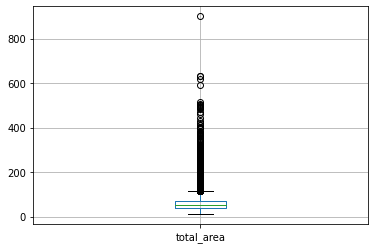

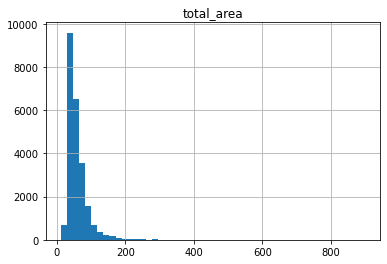

In [17]:
# ящик с усами для общей площади
data.boxplot(column='total_area')

# гистограмма для общей площади
data.hist(column='total_area',bins=50)

# числовое распределение данных
print(data['total_area'].describe())

# просмотрим квартиры с площадью 400
data.loc[data['total_area'] > 400,['last_price','total_area','living_area','kitchen_area','rooms','floors_total','floor','locality_name']]

Среднее и мадианное значение сильно отличаются.75% объявлений - квартиры до 70 кв.м. 
Существует как минимум 1 аномальный выброс, но лучше рассмотреть все значения, больше ~400.
Единственная строчка, к которой есть сомнения - 9826. Однокомнатная квартира, жилой площадью в 18кв.м., но при этом общая площадь почти 500кв.м. Остальное ещё хоть как-то можно представить.

count    23699.000000
mean        34.441157
std         21.802121
min          2.000000
25%         18.400000
50%         30.300000
75%         42.700000
max        409.700000
Name: living_area, dtype: float64

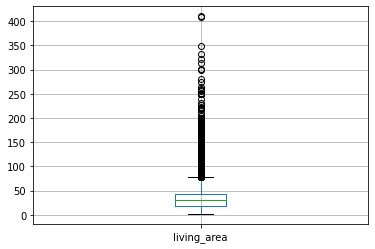

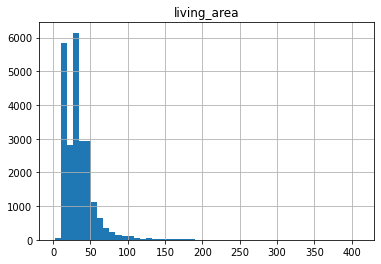

In [18]:
# ящик с усами для жилой площади
data.boxplot(column='living_area')

# гистограмма для жилой площади
data.hist(column='living_area',bins=50)

# числовое распределение данных
data['living_area'].describe()

Среднее и мадианное значение отличаются уже не сильно.
1 из 2 явных выбросов >400кв.м. соответствует тому же объкту, что являюется выбросом по общей площади

count    23699.000000
mean        10.565624
std          6.078027
min          0.000000
25%          7.300000
50%          9.550118
75%         11.600000
max        352.134754
Name: kitchen_area, dtype: float64
count    23699.000000
mean        10.550914
std          5.658720
min          0.000000
25%          7.300000
50%          9.550118
75%         11.600000
max        112.000000
Name: kitchen_area, dtype: float64


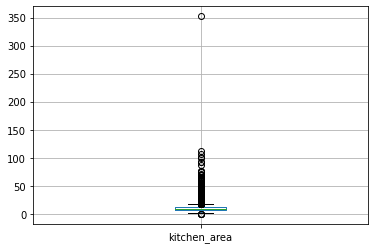

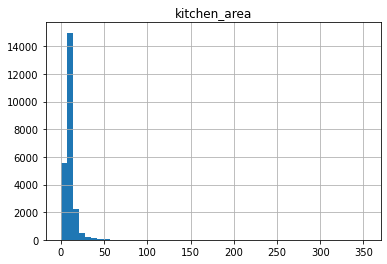

In [19]:
# ящик с усами для площади кухни
data.boxplot(column='kitchen_area')

# гистограмма для площади кухни
data.hist(column='kitchen_area',bins=50)

# числовое распределение данных
print(data['kitchen_area'].describe())

# Рассмотрим строки с площадью кухни более 300 кв.м.
data.loc[data['kitchen_area'] > 300,['total_area','living_area','kitchen_area','rooms']]

# исправим предполагаемую ошибку ввода
data.loc[19392,'kitchen_area'] = data.loc[19392,'kitchen_area']/100
data.loc[19392,'total_area'] = data.loc[19392,'total_area']/10

# проверим распределения еще раз
print(data['kitchen_area'].describe())

Ситуция в целом аналогична жилой площади
Есть один выброс, который при рассмотрении можно предположить ошибкой ввода данных: т.к. это студия, судя по количеству комнат, то общая площадь и площадь кухни увеличены в 100 и в 10 раз соответственно.Руками поменяем данные.
Но площадь кухни не имеет большого разброса и довольно статична.

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km
1436,19,330000000,190.0,2018-04-04,3,3.500000,7,95.0,5,True,...,519.0,3,285.0,233,1.736842e+06,СР,4,2018,Другое,2
12971,19,763000000,400.0,2017-09-30,7,2.771499,10,250.0,10,True,...,530.0,3,756.0,33,1.907500e+06,СБ,9,2017,Последний этаж,4
14706,15,401300000,401.0,2016-02-20,5,2.771499,9,204.0,9,False,...,545.0,1,478.0,393,1.000748e+06,СБ,2,2016,Последний этаж,3
15651,20,300000000,618.0,2017-12-18,7,3.400000,7,258.0,5,True,...,3001.0,2,198.0,111,4.854369e+05,ПН,12,2017,Другое,6
19540,8,420000000,900.0,2017-12-06,12,2.800000,25,409.7,25,True,...,3001.0,2,318.0,106,4.666667e+05,СР,12,2017,Последний этаж,8
22831,18,289238400,187.5,2019-03-19,2,3.370000,6,63.7,6,True,...,386.0,3,188.0,-1,1.542605e+06,ВТ,3,2019,Последний этаж,2


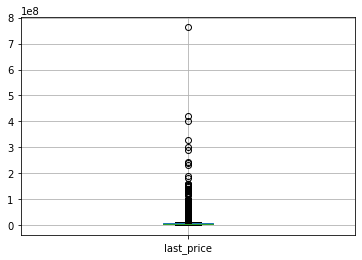

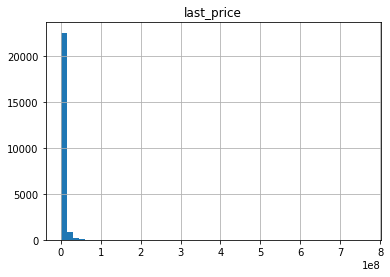

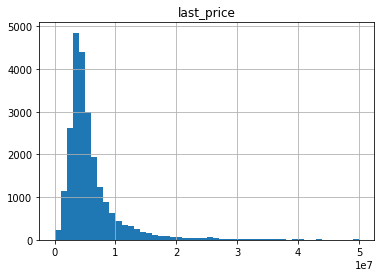

In [20]:
# ящик с усами для цены объекта
data.boxplot(column='last_price')

# гистограмма для цены объекта
data.hist(column='last_price',bins=50)

# гистограмма для площади кухни с ограничением по цене в 50млн
data.hist(column='last_price',bins=50, range=(0,50e6))

# числовое распределение данных
print(data['last_price'].describe())

data.query('last_price > 250000000')

Разброс мин. и макс. цен отличается на 4 порядка. Возможно, что для рынка недвижимости это нормально. Особенно, в столичных регионах.
Квартира площадью в 900 кв.м. так же среди лидеров по стоимости. 
Но основная масса предложений - до 50 млн.

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km
648,3,17500000,183.7,2018-07-01,11,3.400000,7,138.800000,7,True,...,3001.0,0,3001.0,-1,95264.017420,ВС,7,2018,Последний этаж,4
866,5,25000000,363.0,2017-12-23,14,3.160000,5,222.000000,4,True,...,3001.0,2,435.0,418,68870.523416,СБ,12,2017,Другое,8
4149,6,23000000,272.6,2018-01-11,10,3.140000,7,145.900000,7,True,...,191.0,1,531.0,-1,84372.707263,ЧТ,1,2018,Последний этаж,13
5358,20,65000000,590.0,2019-02-14,15,3.500000,6,409.000000,3,True,...,767.0,0,3001.0,14,110169.491525,ЧТ,2,2019,Другое,5
8822,14,49968900,398.0,2017-07-12,9,3.000000,2,160.100000,1,False,...,471.0,2,440.0,471,125550.000000,СР,7,2017,Первый этаж,17
8860,12,17000000,235.0,2018-07-14,9,3.000000,6,190.257143,3,True,...,346.0,0,3001.0,90,72340.425532,СБ,7,2018,Другое,6
9550,10,23500000,313.0,2017-02-13,9,3.200000,6,179.200000,5,True,...,146.0,0,3001.0,-1,75079.872204,ПН,2,2017,Другое,11
9688,8,33000000,194.1,2017-02-07,11,3.430000,5,129.000000,2,True,...,686.0,2,66.0,813,170015.455951,ВТ,2,2017,Другое,2
13019,0,22250000,249.9,2019-04-23,9,3.200000,5,157.000000,5,True,...,352.0,0,3001.0,-1,89035.614246,ВТ,4,2019,Последний этаж,10
13397,14,19500000,309.7,2016-02-03,9,2.771499,5,199.000000,5,True,...,352.0,0,3001.0,468,62964.158863,СР,2,2016,Последний этаж,10


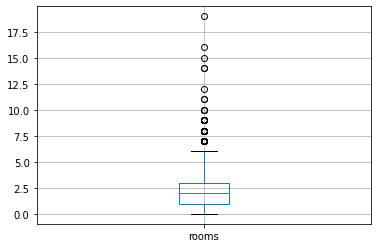

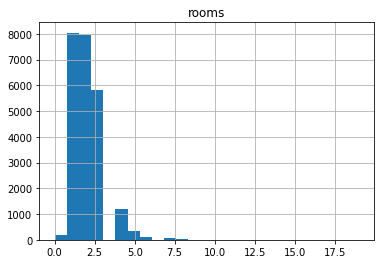

In [21]:
##### ящик с усами для количества комнат
data.boxplot(column='rooms')

# гистограмма для количества комнат
data.hist(column='rooms',bins=25)

# числовое распределение данных
print(data['rooms'].describe())

# квартиры с количеством комнат более 8
data.query('rooms > 8')

Разброс по количеству комнат так же большой. 19ти комнатная квартира? Возможно. И площадь подходящая. Но таких предложений не так много и при анализе ими можно будет пренебречь. Они будут выглядеть как одиночные выбросы. В основном же, на рынке стандартно 1-2-3х-комнатные квартиры. 

count    23699.000000
mean         2.745861
std          0.251050
min          1.000000
25%          2.600000
50%          2.771499
75%          2.771499
max         14.000000
Name: ceiling_height, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km
3474,3,1400000,30.0,2018-03-16,1,8.00,5,15.3,2,False,...,3001.0,0,3001.0,125,46666.666667,ПТ,3,2018,Другое,0
5712,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,True,...,3001.0,0,3001.0,248,35046.728972,ПН,8,2017,Первый этаж,0
5863,20,5650000,45.0,2018-08-15,1,8.30,16,19.3,14,True,...,3001.0,1,613.0,14,125555.555556,СР,8,2018,Другое,11
15061,19,5600000,56.4,2018-05-11,2,14.00,14,32.4,5,True,...,3001.0,0,3001.0,315,99290.780142,ПТ,5,2018,Другое,14
15743,14,5600000,67.0,2016-11-11,3,8.00,16,41.0,1,True,...,723.0,0,3001.0,474,83582.089552,ПТ,11,2016,Первый этаж,12
16934,5,4100000,40.0,2017-10-17,1,1.75,37,17.4,5,True,...,3001.0,3,80.0,71,102500.000000,ВТ,10,2017,Другое,21
17442,0,5350000,54.0,2015-06-16,2,8.00,5,29.0,2,True,...,3001.0,0,3001.0,469,99074.074074,ВТ,6,2015,Другое,29
22309,20,5300000,45.0,2017-09-30,1,10.30,16,15.5,15,True,...,440.0,2,450.0,136,117777.777778,СБ,9,2017,Другое,12
22590,16,6000000,55.0,2018-10-31,2,1.00,12,32.4,7,True,...,293.0,2,289.0,13,109090.909091,СР,10,2018,Другое,15
22869,0,15000000,25.0,2018-07-25,1,10.00,5,14.0,5,True,...,223.0,3,30.0,19,600000.000000,СР,7,2018,Последний этаж,9


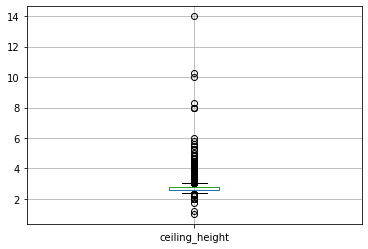

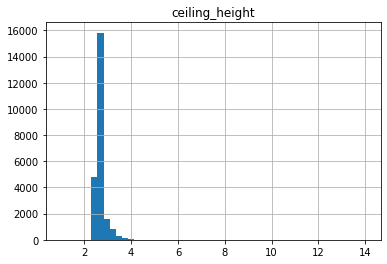

In [22]:
# ящик с усами для высоты потолков
data.boxplot(column='ceiling_height')

# гистограмма для высот потолков
data.hist(column='ceiling_height',bins=50)

# числовое распределение данных
print(data['ceiling_height'].describe())

# просмотрим квартиры с аномальными потолками (более 6м или менее 2м)
data.query('ceiling_height > 6 or ceiling_height < 2')


Даже несмотря на то, что во время предобработки высоты потолков более 19 метров были понижены на один порядок, всё равно остались аномальные значения как в большую сторону >6м так и в меньшую <2м
Пока оставляем, но не забываем о них. В целом, высота потолков соответствует строительным нормам.

count      23699
unique         3
top       Другое
freq       17474
Name: floor_type, dtype: object


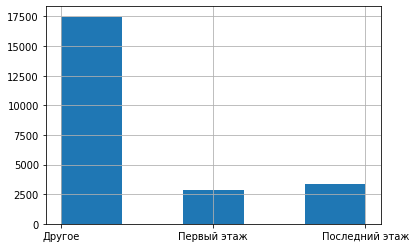

In [23]:
# Гистограмма для типов этажей квартир
data['floor_type'].hist(bins=5)

# числовое распределение данных
print(data['floor_type'].describe())

Тут ничего удивительного. Естественно, что квартир не на первом и не на последнем этажах больше не в один и не в 2 раза.
И продается их больше. Поэтому распределение вполне ожидаемое.

count    23699.000000
mean        10.635090
std          6.616396
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km
397,15,5990000,54.0,2018-03-22,2,2.771499,36,21.400000,28,True,...,3001.0,3,80.0,11,110925.925926,ЧТ,3,2018,Другое,21
871,14,7777777,75.0,2017-11-16,2,2.771499,35,40.500000,23,True,...,3001.0,3,80.0,169,103703.693333,ЧТ,11,2017,Другое,21
1060,10,5200000,50.0,2015-11-06,2,2.771499,35,39.000000,15,False,...,3001.0,3,80.0,281,104000.000000,ПТ,11,2015,Другое,21
1697,11,3550000,28.0,2018-02-08,1,2.650000,34,18.000000,23,True,...,3001.0,3,80.0,410,126785.714286,ЧТ,2,2018,Другое,21
1917,13,10150000,74.0,2017-11-17,2,2.800000,35,34.400000,30,True,...,3001.0,3,80.0,-1,137162.162162,ПТ,11,2017,Другое,21
2253,12,3800000,45.5,2018-06-28,2,2.880000,60,27.400000,4,True,...,342.0,3,614.0,166,83516.483516,ЧТ,6,2018,Другое,50
2966,9,4300000,37.0,2017-08-08,1,2.771499,35,14.000000,15,True,...,3001.0,3,80.0,50,116216.216216,ВТ,8,2017,Другое,21
4855,12,5500000,50.0,2017-06-22,1,2.800000,35,22.000000,4,True,...,609.0,3,145.0,537,110000.000000,ЧТ,6,2017,Другое,21
5749,20,3590000,25.0,2017-08-30,0,2.800000,35,18.865246,26,True,...,3001.0,3,80.0,198,143600.000000,СР,8,2017,Другое,21
5807,17,8150000,80.0,2019-01-09,2,2.700000,36,41.000000,13,True,...,3001.0,3,80.0,38,101875.000000,СР,1,2019,Другое,21


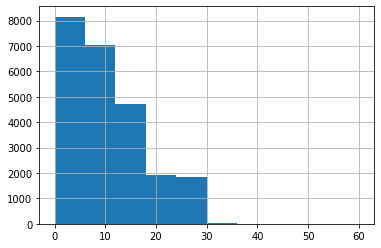

In [24]:
# гистограмма для общего количества этажей в домах
data['floors_total'].hist()

# числовое распределение данных
print(data['floors_total'].describe())

data.query('floors_total > 30')

Тоже ничего необычного. Большинство предложений из многоэтажек до 13 этажей.
Предложений из 30+ этажных домов довольно мало. А если обратить внимание на колонку city_center_nearest_km, то можно
предположить, что большинство этих квартир продаются в одном доме в 35 этажей. Возможно, что это новостройка или ЖК?

count    23699.000000
mean        11.347103
std          9.730296
min          0.000000
25%          3.000000
50%         12.000000
75%         16.000000
max         66.000000
Name: city_center_nearest_km, dtype: float64


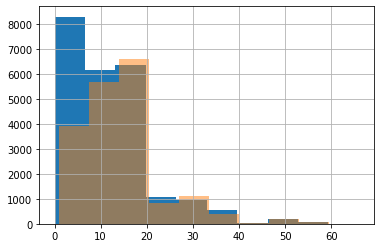

In [25]:
# гистограмма расстояния до центра города в километрах для всех данных
data['city_center_nearest_km'].hist()

# гистограмма расстояния до центра города в километрах для всех данных за исклюением обнуленных при предобработке
data[data['city_center_nearest_km']>0]['city_center_nearest_km'].hist(alpha=0.5)

# числовое распределение данных
print(data['city_center_nearest_km'].describe())

Тоже не видно ничего особенного. Распределение вполне ожидаемое(Синий)
Еще нужно помнить о том, что неуказанные  расстояния я обнулил, поэтому для корректности убраем их из отображения(Оранжевый)

count    23699.000000
mean      2145.273218
std       1206.555797
min          1.000000
25%        601.000000
50%       3001.000000
75%       3001.000000
max       3190.000000
Name: parks_nearest, dtype: float64


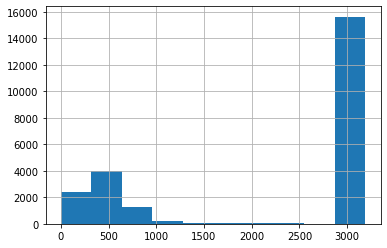

In [26]:
# гистограмма расстояний до ближайшего парка
data['parks_nearest'].hist(bins=10)

# числовое распределение данных
print(data['parks_nearest'].describe())

Неуказанные расстояния в исходной таблице были заменены на 3001(м). Поэтому здесь и наблюдается всплеск. Но он говорит только о том, что до ближайшего парка больше 3х км.

In [38]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,month,year,city_center_nearest_km
count,"23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000",...,"23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000","23,699.000"
mean,9.858,"6,541,548.772",60.335,2.071,2.746,10.635,34.441,5.892,10.551,0.591,...,"10,935.877",0.469,"2,145.273",0.591,"2,046.517",156.475,"99,421.656",6.400,"2,017.367",11.347
std,5.683,"10,887,013.268",35.597,1.078,0.251,6.616,21.802,4.885,5.659,0.959,...,"9,621.813",0.749,"1,206.556",0.884,"1,220.111",213.646,"50,306.802",3.492,1.040,9.730
min,0.000,"12,190.000",12.000,0.000,1.000,0.000,2.000,1.000,0.000,0.000,...,0.000,0.000,1.000,0.000,13.000,-1.000,111.835,1.000,"2,014.000",0.000
25%,6.000,"3,400,000.000",40.000,1.000,2.600,5.000,18.400,2.000,7.300,0.000,...,"2,410.000",0.000,601.000,0.000,637.000,22.000,"76,585.470",3.000,"2,017.000",3.000
50%,9.000,"4,650,000.000",52.000,2.000,2.771,9.000,30.300,4.000,9.550,0.000,...,"11,308.000",0.000,"3,001.000",0.000,"3,001.000",74.000,"95,000.000",6.000,"2,017.000",12.000
75%,14.000,"6,800,000.000",69.850,3.000,2.771,16.000,42.700,8.000,11.600,1.000,...,"15,255.000",1.000,"3,001.000",1.000,"3,001.000",199.000,"114,256.326",10.000,"2,018.000",16.000
max,50.000,"763,000,000.000",900.000,19.000,14.000,60.000,409.700,33.000,112.000,5.000,...,"65,968.000",3.000,"3,190.000",3.000,"3,001.000","1,580.000","1,907,500.000",12.000,"2,019.000",66.000


<b>Как быстро продавались квартиры<b>

Среднее время продажи: 181.0 день(дней)
Медианное время продажи: 95.0 день(дней)
Я думаю, что быстрые продажи - это продажи, совершенные менее, чем за 45.0 дней
А медленные - совершенные более, чем за 232.0 дней


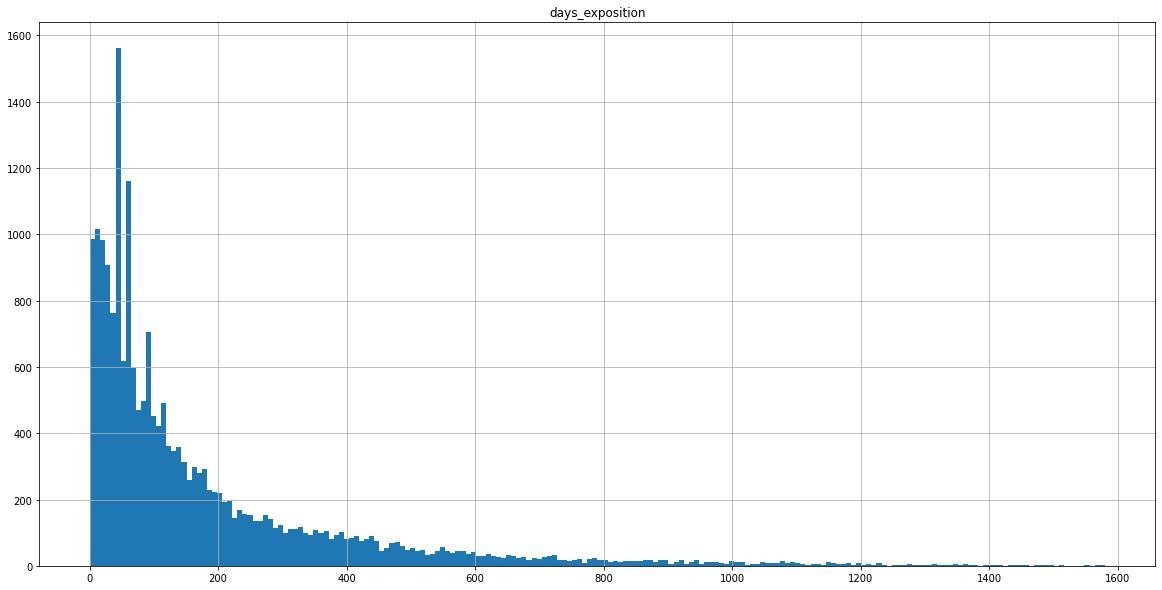

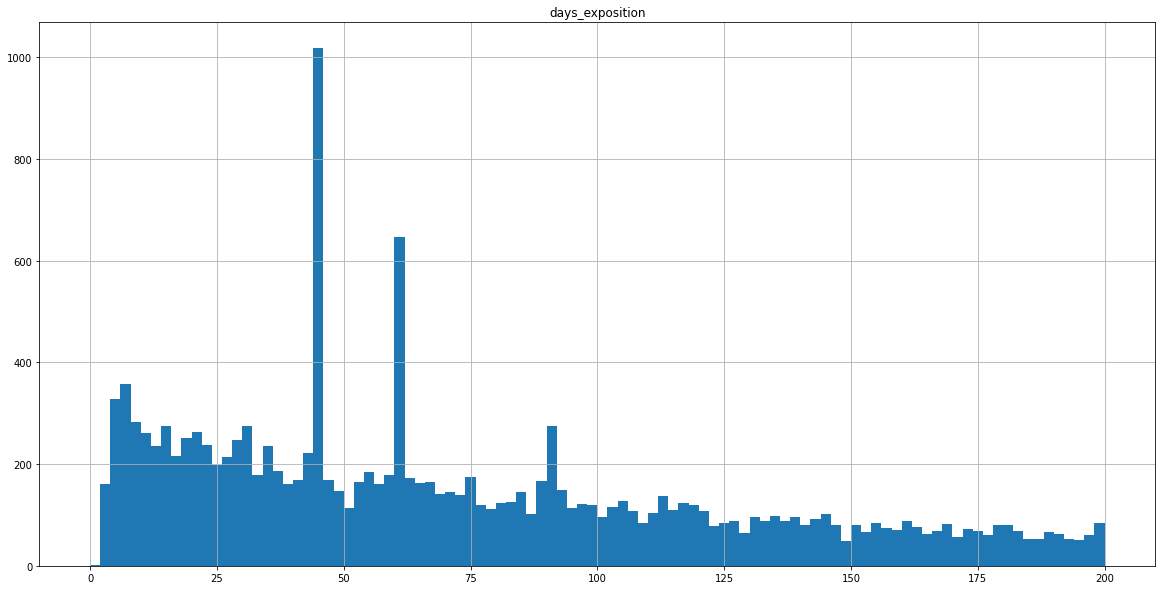

In [27]:
data[data['days_exposition']>0].hist(column='days_exposition',bins=200,figsize=(20,10)) # все продажи
data[data['days_exposition']>0].hist(column='days_exposition',bins=100,figsize=(20,10),range=(0,200)) # продажи до 200хсот дней

# числовое распределение известных данных
desc = data[data['days_exposition']>0]['days_exposition'].describe()

print('Среднее время продажи:',desc['mean'].round(),'день(дней)')
print('Медианное время продажи:',desc['50%'].round(),'день(дней)')

print('Я думаю, что быстрые продажи - это продажи, совершенные менее, чем за',desc['25%'].round(),'дней')
print('А медленные - совершенные более, чем за',desc['75%'].round(),'дней')



Собственно. Продажи быстрее Q1-быстрые. Между Q1 и Q3 - обычное время на продажу квартиры. Всё, что дольше Q3 - затянувшаяся.
Если укрупнить продажи от 0 до 200 дней, то видны 2 пика как раз в районе 45 и 60 дней, т.е. как раз во время типичной продажи

<b>Факторы, которые больше всего влияют на общую (полную) стоимость объекта<b>

Коэффициент корреляции: 0.6523752726680954


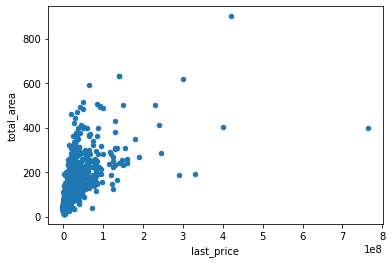

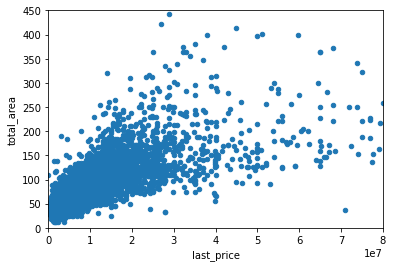

In [28]:
# Зависимость цены от общей площади
data.plot.scatter(x='last_price',y='total_area')

data.plot.scatter(x='last_price',y='total_area',ylim=(0,450),xlim=(0,8E7))

print('Коэффициент корреляции:',data['last_price'].corr(data['total_area']))

Эта и следующие диаграммы рассеяния представленны в 2х видах: общий и "укрупненный", с ограничением по шкалам X и/или Y, отсеивая таким образом выбросы данных. При этом коэффициент корреляции подсчитан для всего набора.

Коэффициент корреляции: 0.5564104267344321


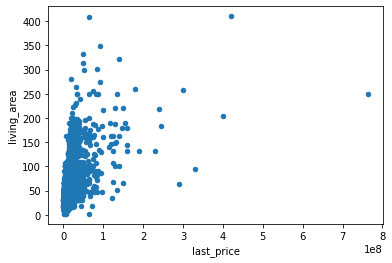

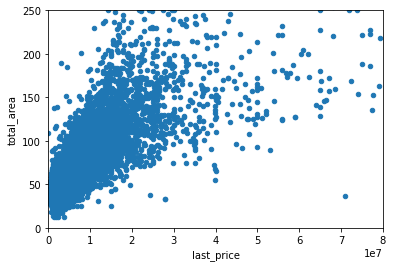

In [29]:
# Зависимость цены от жилой площади
data.plot.scatter(x='last_price',y='living_area')

data.plot.scatter(x='last_price',y='total_area',ylim=(0,250),xlim=(0,8E7))

print('Коэффициент корреляции:',data['last_price'].corr(data['living_area']))

Коэффициент корреляции: 0.45702864078038996


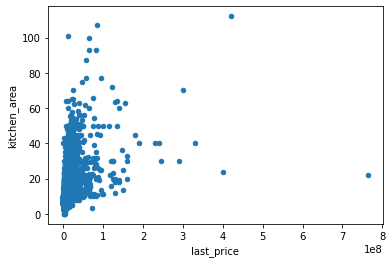

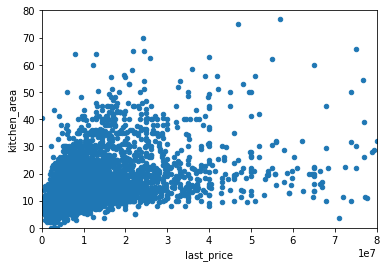

In [30]:
# Зависимость цены от площади кухни
data.plot.scatter(x='last_price',y='kitchen_area')

data.plot.scatter(x='last_price',y='kitchen_area',ylim=(0,80),xlim=(0,8E7))

print('Коэффициент корреляции:',data['last_price'].corr(data['kitchen_area']))

Коэффициент корреляции: 0.3633428499648948


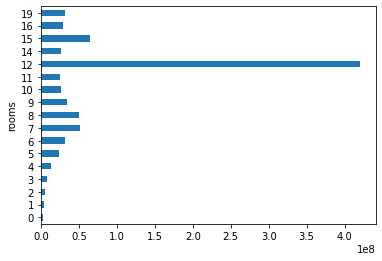

In [31]:
# Зависимость цены от количества комнат
(data.groupby('rooms')['last_price'].mean()).plot(kind='barh')

print('Коэффициент корреляции:',data['last_price'].corr(data['rooms']))

Как видно, с ростом количества комнат цена начинает рости. Потом в какой-то момент закономерность пропадает. Это связано с тем, что основная часть данных - это квартиры до 5 комнат. Остальное - это уникальные предложения с единичными ценами. В реальной жизни, я бы уточнил, стоит ли учитывать такие "неходовые" предложения в общей массе или их рассматривать отдельно, или вообще не рассматривать.

Зависимость цены от типа этажа


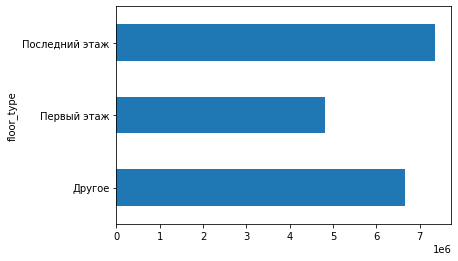

In [32]:
# Зависимость цены от типа этажа
(data.groupby('floor_type')['last_price'].mean()).plot(kind='barh')

print('Зависимость цены от типа этажа')

Да, данные снова повтрояют нам, что самые дешевые квартиры на первых этажах.
Последние этажи вытягивают в цене за счет, возможно, премиум-сегмента с многоуровневыми квартирами на последних этажах и пентхаусов.

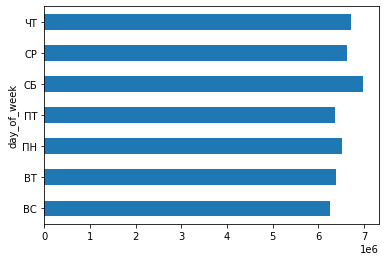

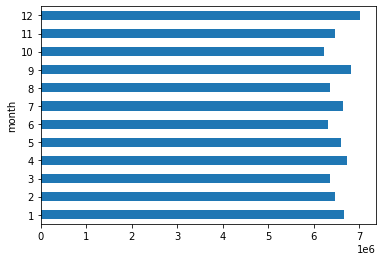

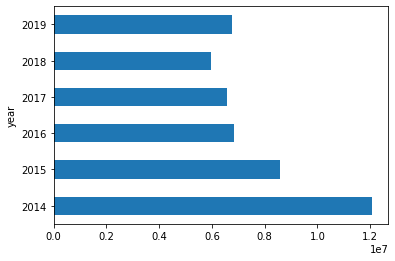

Зависимость цены от даты размещения ниже по тексту


In [33]:
>>> import matplotlib.pyplot as plt
# Зависимость цены от даты размещения
(data.groupby('day_of_week')['last_price'].mean()).plot(kind='barh')
plt.show()
(data.groupby('month')['last_price'].mean()).plot(kind='barh')
plt.show()
(data.groupby('year')['last_price'].mean()).plot(kind='barh')
plt.show()

print('Зависимость цены от даты размещения ниже по тексту')

<b>Вывод по зависимости цены от параметров</b>
    <ul>
        <li> <b>Общая площадь:</b></li>
            По графикам, даже с учетом выбросов, которые есть в данных, коэффициент корреляции составляет 0.65, что дает основание полагать наличие зависимости стоимости от общей площади квартиры
        <li> <b>Жилая площадь:</b></li>
    Аналогично общей площади, прямая зависимость есть. Коэффициент корреляции 0.55
        <li> <b>Площадь кухни:</b></li>
    Как и по остальным площадям, прямая зависимость прослеживается, хотя и значительно меньше: коэффициент корреляции 0.46
        <li> <b>Этаж квартиры:</b></li>
    Графики подтверждают общее мнение о зависимости стоимости от этажа: квартиры на первом заметно дешевле, чем квартиры на средних этажах. Причем, на первом еще дешевле, чем на последнем.<br>Последние этажи вытягивают в цене за счет, возможно, премиум-сегмента с многоуровневыми квартирами на последних этажах и пентхаусов.
        <li> <b>Дата размещения:</b></li>
    Самые пртиворечивые графики, по которым сложно найти зависимости. Можно найти только замечания: <br>более дешевые квартиры выставляются на продажу про воскресеньям<br>цена заметно не зависит от месяца размещения<br>Квартиры в 2014 стоили дешевле, чем в остальные годы. Внимание привлекает 2017 год. По сообщениям информационных сайтов этот год был рекордным по количеству совершенных сделок и стоимости недвижимости. Чему поспособствовали низкие ипотечные ставки и начало программы реновации и сноса 5ти-этажек.
    </ul>
            

<b>Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений</b>

In [34]:
pd.options.display.float_format ='{:,.3f}'.format
pt = data.pivot_table(index='locality_name',values='1m_price',aggfunc=['median','count'])
pt.columns = [('median'),('count')]
pt = pt.sort_values(by=['count','median'],ascending=False)
pt.columns = [('Средняя цена 1 кв.м.'),('Кол-во объявлений')]
print('Населенные пункты с самой высокой ценой за 1кв.м. жилплощади по количеству объявлений:\n\n',pt.head(10))

pt = pt.sort_values(by=['Средняя цена 1 кв.м.'],ascending=False)
print('\n\nНаселенные пункты с самой высокой ценой за 1кв.м. жилплощади:\n\n',pt.head(10))
print('\n\nНаселенные пункты с самой низкой ценой за 1кв.м. жилплощади:\n\n',pt.tail(10))

Населенные пункты с самой высокой ценой за 1кв.м. жилплощади по количеству объявлений:

                  Средняя цена 1 кв.м.  Кол-во объявлений
locality_name                                           
Санкт-Петербург           104,761.905              15721
Мурино                     86,175.644                590
Кудрово                    95,675.474                472
Шушары                     76,876.173                440
Всеволожск                 65,789.474                398
Пушкин                    100,000.000                369
Колпино                    74,723.748                338
Парголово                  91,642.857                327
Гатчина                    67,796.610                307
Выборг                     58,158.320                237


Населенные пункты с самой высокой ценой за 1кв.м. жилплощади:

                  Средняя цена 1 кв.м.  Кол-во объявлений
locality_name                                           
Санкт-Петербург           104,761.905          

<b>Квартиры в Санкт-Петербурге и их средняя стоимость на разном удалении от центра</b>

Категории расстояния от центра города:
1 - от 0 до 1км
2 - от 1 до 2км
3 - от 2 до 3км       
4 - от 3 до 4км
5 - от 4 до 5км
и так далее

    dist_cat   Средняя цена  Кол-во объявлений
0          1 23,442,315.442                 86
1          2 18,850,851.663                240
2          3 16,163,313.616                307
3          4 13,436,830.553                526
4          5 13,632,024.645                907
5          6 15,306,121.120                769
6          7 14,389,106.185                470
7          8 12,797,673.740                407
8          9  8,445,271.997                670
9         10  6,426,054.857                690
10        11  6,376,091.669                912
11        12  6,378,591.273               1476
12        13  5,980,211.397               1520
13        14  6,016,125.467               1398
14        15  5,768,323.754               1511
15        16  5,545,776.114               1373
16        17  5,527,927.703               1106
17        18  4

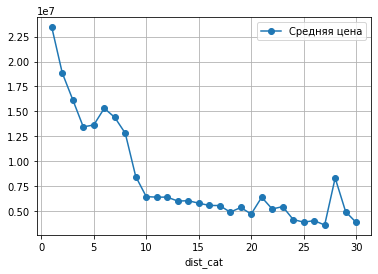

In [35]:
import math

spb_ad = (
    data.query('locality_name =="Санкт-Петербург"')
    .loc[:,['locality_name','last_price','city_center_nearest_km']]
)

def distance_category(km):
    try:
        return math.ceil(km)
    except: return -1

spb_ad['dist_cat'] = spb_ad['city_center_nearest_km'].apply(distance_category)
spb_ad = spb_ad.pivot_table(index='dist_cat', values='last_price', aggfunc=['mean','count'])
spb_ad.columns = [('Средняя цена'),('Кол-во объявлений')]
spb_ad.reset_index(inplace=True)
spb_ad.plot(x='dist_cat',y='Средняя цена',grid=True,style='o-')
print('Категории расстояния от центра города:\n1 - от 0 до 1км\n2 - от 1 до 2км\n3 - от 2 до 3км\
       \n4 - от 3 до 4км\n5 - от 4 до 5км\nи так далее\n')
print(spb_ad)

Логичный вывод: чем ближе к центру, тем более дорогая недвижимость.
Есть 2 пика, выделяющихся по цене - на расстоянии 4-5 км и 27-28 км.
Можно рассмотреть причину отдельно

In [36]:
data.query('5<city_center_nearest_km<6').sort_values(by='last_price',ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km


In [37]:
data.query('27<city_center_nearest_km<28').sort_values(by='last_price',ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m_price,day_of_week,month,year,floor_type,city_center_nearest_km


И в первом и во втором случае мы видим квартиры по превышающей среднюю цену стоимости в домах одинаковой этажности.
Возможно, это один и и тот же дом: новостройка или дом, относящийся к премиум сегменту для данного района.

### Напишите общий вывод

Во время данной работы был обработан файл с архивом объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.<br><br>
В ходе предобработки были заполнены пропущенные значения в столбцах, полученных от пользователя и от системы, добавляющей количество объектов и ближайшее расстояние до них: пруды, парки, аэропорты, центр города. <br><br>
Были удалены неявные дубликаты в географических названиях населенных пунктов.<br><br>
Были исправлены некоторые строки, которые походили на аномальные или на ошибку ввода.<br><br>
Были добавлены столбцы, которые в дальнейшем использовались для анализа данных, например, стоимость 1 кв.м. площади недвижимости.<br><br>
Во время анализа были изучены данные по надвижимости, такие как площади: общая, жилая и кухонной зоны, стоимость объекта, количество комнат, высота потолков, этаж расположения квартиры, общее количество этажей в доме, расстояния до центра города и до ближайшего парка.<br><br>
Были получены результаты о сроках продажи квартир. Сделано разделение на быстро продаваемые и медленно продаваемые объекты на основе количества дней, которые квартира находилась в продаже. Определенно среднее и медианное время продажи.<br><br>
Были найдены зависимости стоимости недвижимости от площадей: общей, жилой и кухонной, от количества комнат, этажа и даты размещения объявления.<br><br>
Была подсчитана средняя цена 1 кв.м. площади в 10 населенных пунктах с наибольшим числом объявлений. Выделены населенные пункты с самой высокой и самой низкой стоимостью квадратного метра.<br><br>
Была рассчитана средняя стоимость квартиры в Санкт-Петербурге, с разбивкой по удалению от центра города с шагом в 1км. Описана закономерность и построен график.
